In [263]:
import chirho.observational.handlers
import pyro
import torch
import pyro.distributions as dist
from chirho.interventional.handlers import Interventions, do
from chirho.counterfactual.handlers.counterfactual import TwinWorldCounterfactual
from chirho.counterfactual.handlers.counterfactual import MultiWorldCounterfactual
from chirho.indexed.ops import gather, IndexSet
from functools import singledispatch
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal, AutoNormal
from functools import partial
from chirho.indexed.ops import gather, IndexSet
from chirho.observational.handlers import condition
from chirho.observational.handlers.condition import Observations
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, sqrt
from itertools import product
from random import randint
from contextlib import nullcontext
import matplotlib
from utils.build_svi_iter import build_svi_iter
from utils.build_zuko_guide import build_zuko_guide
from chirho.observational.handlers.predictive import PredictiveModel
import seaborn as sns
from chirho.robust.ops import influence_fn
from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator

tnsr = torch.tensor

# Settings
pyro.settings.set(module_local_params=True)
torch.set_default_dtype(torch.float64)


seed = randint(0, int(1e6))
print(seed)

#seed = ___

pyro.set_rng_seed(seed)

760620


# Simple Model

In [264]:
# Sample from an MVN by sampling two normals sequentially.
class ChainedNormals(torch.nn.Module):
    def __init__(self, loc, cov, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.loc1 = loc[0]
        self.std1 = torch.sqrt(cov[0, 0])
        
        self.loc2_base = loc[1]
        self.sigma_21 = cov[1, 0]
        self.sigma_11 = cov[0, 0]
        self.sigma_22 = cov[1, 1]
        
        # Precompute part of the conditional mean expression
        self.conditional_loc2_base = self.loc2_base - (self.sigma_21 / self.sigma_11) * self.loc1
        self.conditional_std2 = torch.sqrt(self.sigma_22 - (self.sigma_21**2 / self.sigma_11))
    
    def forward(self):
        # Sample from the first normal distribution
        z1 = pyro.sample("z1", dist.Normal(
            loc=self.loc1,
            scale=self.std1
        ))
        
        # Compute the conditional mean using the sampled z1
        conditional_loc2 = self.conditional_loc2_base + (self.sigma_21 / self.sigma_11) * z1
        
        # Sample from the second normal distribution with the conditional mean
        z2 = pyro.sample("z2", dist.Normal(
            loc=conditional_loc2,
            scale=self.conditional_std2
        ))
        
        return z1, z2

In [265]:
prior = ChainedNormals(
    loc=torch.tensor([0., 0.]),
    cov=torch.tensor([
        [5.0, -0.0],
        [-0.0, 5.0]
    ])
)

Text(0.5, 0.98, 'Prior Samples')

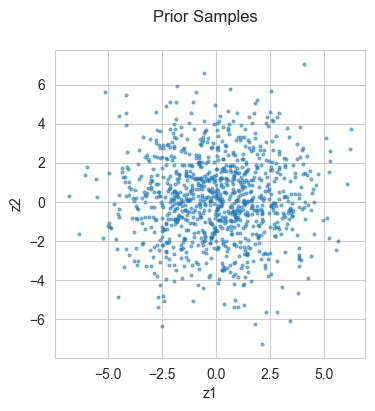

In [283]:
# Visualize samples from the prior.
with pyro.plate("prior_viz", 1000):
    prior_samples = prior()

plt.figure(figsize=(4, 4))
plt.scatter(prior_samples[0].detach().numpy(), prior_samples[1].detach().numpy(), alpha=0.5, s=4.)
plt.xlabel("z1")
plt.ylabel("z2")
plt.suptitle("Prior Samples")

In [267]:
class FullModel(torch.nn.Module):
    def __init__(self, prior: torch.nn.Module, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.prior = prior
        
    def forward(self, n=1):
        z1, z2 = self.prior()
        with pyro.plate("data", n, dim=-1):
            x = pyro.sample("x", dist.Normal(z1 + z2, 0.5))
    
        return x
model = FullModel(prior)

# Data Generation

In [268]:
true_latents = dict(
    z1=tnsr([1.]),
    z2=tnsr([-3.])
)

In [269]:
N = 100
observed_data = dict(x=condition(partial(model, n=N), data=true_latents)())

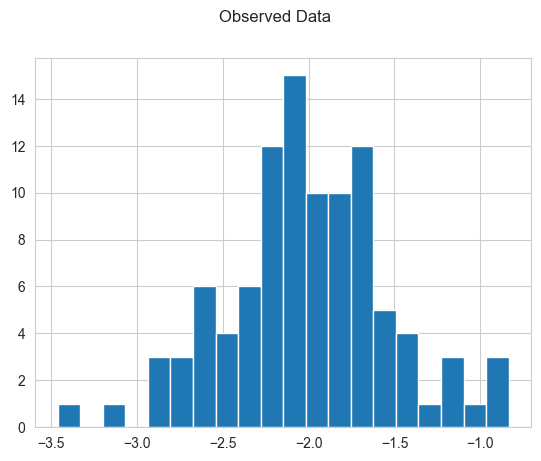

In [282]:
plt.hist(observed_data["x"].detach().numpy(), bins=20)
plt.suptitle("Observed Data")
pass

In [271]:
conditioned_model = condition(partial(model, n=N), data=observed_data)

# Inference

In [272]:
svi = build_svi_iter(
    model=conditioned_model,
    lr=1e-3,
    # block_latents=["z1", "z2"],
    # variational_family=AutoMultivariateNormal,
    # variational_family=AutoDelta,
    variational_family=build_zuko_guide,
    features=2,
    context=0,
    transforms=1,
    hidden_features=(32, 32)
)

In [273]:
NITER = 5000
for _ in range(NITER):
    print(f"Progress {_}/{NITER}", end="\r")
    svi.svi_iter()

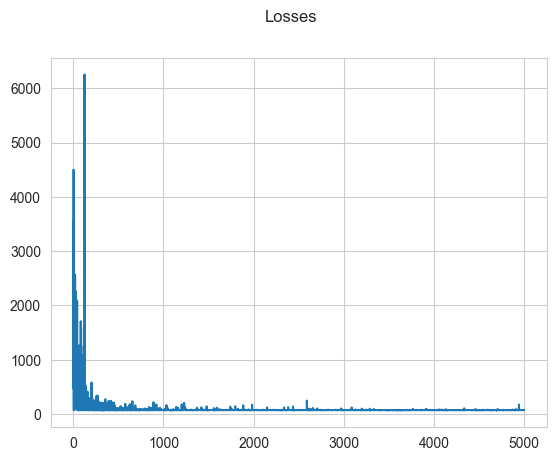

In [284]:
plt.plot(svi.losses)
plt.suptitle("Losses")
pass

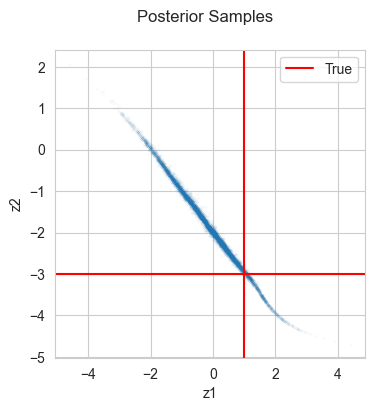

In [280]:
# Plot posterior samples.
with pyro.plate("posterior_viz", 1e4):
    posterior_samples = svi.guide()
    
plt.figure(figsize=(4, 4))
plt.scatter(posterior_samples["z1"].detach().numpy(), posterior_samples["z2"].detach().numpy(), alpha=1.0, s=0.001)
plt.axvline(true_latents["z1"].item(), color="red", label="True")
plt.axhline(true_latents["z2"].item(), color="red")
plt.xlabel("z1")
plt.ylabel("z2")
plt.legend()
plt.suptitle("Posterior Samples")
pass

# Functional

In [306]:
class IntervenedSum(torch.nn.Module):
    
    def __init__(self, model, z2value, num_monte_carlo, reshaper=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model
        self.z2value = z2value
        self.num_monte_carlo = num_monte_carlo
        self.reshaper = reshaper or (lambda x: x)
        
    def forward(self, *args, **kwargs):
        with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=-2):
            with do(actions=dict(z2=self.z2value)):
                x = self.model(*args, **kwargs)
                return self.reshaper(x)

In [305]:
functional = IntervenedSum(model, z2value=tnsr([0.]), num_monte_carlo=1000, reshaper=torch.mean)

# Posterior Sensitivity

In [311]:
# Generate a grid of z1, z2 value pairs to assess sensitivity wrt.
GRID_RES = 300
z1_values = torch.linspace(-5., 5., GRID_RES)
z2_values = torch.linspace(-5., 5., GRID_RES)
z1_grid, z2_grid = torch.meshgrid(z1_values, z2_values, indexing='ij')

In [ ]:
compute_influence = influence_fn(
    functional,
    dict(z1=z1_grid.reshape(-1), z2=z2_grid.reshape(-1)),
)(predictive)

# with MonteCarloInfluenceEstimator(num_samples_inner=112, num_samples_outer=96):
with MonteCarloInfluenceEstimator(num_samples_inner=1000, num_samples_outer=1000):
    with torch.no_grad():
        influence = compute_influence()